In [1]:
using Plots
using TensorCrossInterpolation, LinearAlgebra
using QuanticsTCI
using QuanticsGrids
using ITensorMPS
using ITensors
using TCIITensorConversion

In [2]:
function f(x)
    return cos(x)
end

f (generic function with 1 method)

In [3]:
R = 10
xmin = 0.0
xmax = 2 * π
dx = float(abs(xmin - xmax) / 2^R)
qgrid = DiscretizedGrid{1}(R, xmin, xmax; includeendpoint = true)
s = siteinds("S=1/2", R)

10-element Vector{Index{Int64}}:
 (dim=2|id=629|"S=1/2,Site,n=1")
 (dim=2|id=840|"S=1/2,Site,n=2")
 (dim=2|id=779|"S=1/2,Site,n=3")
 (dim=2|id=211|"S=1/2,Site,n=4")
 (dim=2|id=670|"S=1/2,Site,n=5")
 (dim=2|id=329|"S=1/2,Site,n=6")
 (dim=2|id=216|"S=1/2,Site,n=7")
 (dim=2|id=854|"S=1/2,Site,n=8")
 (dim=2|id=310|"S=1/2,Site,n=9")
 (dim=2|id=66|"S=1/2,Site,n=10")

In [4]:
ci, ranks, errors = quanticscrossinterpolate(Float64, f, qgrid; tolerance=1e-8)

(QuanticsTCI.QuanticsTensorCI2{Float64}(TensorCrossInterpolation.TensorCI2{Float64} with rank 2, DiscretizedGrid{1}(10, (0.0,), (6.283185307179586,), 2, :fused, true), TensorCrossInterpolation.CachedFunction{Float64, BitIntegers.UInt256} with 237 entries), [2, 2, 2], [4.440892098500626e-16, 4.440892098500626e-16, 4.440892098500626e-16])

In [5]:
mps = ITensorMPS.MPS(TensorTrain(ci.tci), sites=s)

MPS
[1] ((dim=2|id=629|"S=1/2,Site,n=1"), (dim=2|id=596|"l=1,link"))
[2] ((dim=2|id=596|"l=1,link"), (dim=2|id=840|"S=1/2,Site,n=2"), (dim=2|id=316|"l=2,link"))
[3] ((dim=2|id=316|"l=2,link"), (dim=2|id=779|"S=1/2,Site,n=3"), (dim=2|id=881|"l=3,link"))
[4] ((dim=2|id=881|"l=3,link"), (dim=2|id=211|"S=1/2,Site,n=4"), (dim=2|id=172|"l=4,link"))
[5] ((dim=2|id=172|"l=4,link"), (dim=2|id=670|"S=1/2,Site,n=5"), (dim=2|id=364|"l=5,link"))
[6] ((dim=2|id=364|"l=5,link"), (dim=2|id=329|"S=1/2,Site,n=6"), (dim=2|id=120|"l=6,link"))
[7] ((dim=2|id=120|"l=6,link"), (dim=2|id=216|"S=1/2,Site,n=7"), (dim=2|id=260|"l=7,link"))
[8] ((dim=2|id=260|"l=7,link"), (dim=2|id=854|"S=1/2,Site,n=8"), (dim=2|id=283|"l=8,link"))
[9] ((dim=2|id=283|"l=8,link"), (dim=2|id=310|"S=1/2,Site,n=9"), (dim=2|id=712|"l=9,link"))
[10] ((dim=2|id=712|"l=9,link"), (dim=2|id=66|"S=1/2,Site,n=10"))


In [6]:
function custom_mpo(::Type{ElT}, sites::Vector{<:Index}, linkdim::Int) where {ElT<:Number}
    N = length(sites)
    v = Vector{ITensor}(undef, N)
    if N == 0
      return MPO()
    elseif N == 1
      v[1] = ITensor(ElT, dag(sites[1]), sites[1]')
      return MPO(v)
    end
    space_ii = linkdim
    l = [Index(space_ii, "Link,l=$ii") for ii in 1:(N - 1)]
    for ii in eachindex(sites)
      s = sites[ii]
      if ii == 1
        v[ii] = ITensor(ElT, dag(s), s', l[ii])
      elseif ii == N
        v[ii] = ITensor(ElT, dag(l[ii - 1]), dag(s), s')
      else
        v[ii] = ITensor(ElT, dag(l[ii - 1]), dag(s), s', l[ii])
      end
    end
  return MPO(v)
end

custom_mpo (generic function with 1 method)

In [7]:
mpo = custom_mpo(ComplexF64, s, 3)

MPO
[1] ((dim=2|id=629|"S=1/2,Site,n=1"), (dim=2|id=629|"S=1/2,Site,n=1")', (dim=3|id=854|"Link,l=1"))
[2] ((dim=3|id=854|"Link,l=1"), (dim=2|id=840|"S=1/2,Site,n=2"), (dim=2|id=840|"S=1/2,Site,n=2")', (dim=3|id=179|"Link,l=2"))
[3] ((dim=3|id=179|"Link,l=2"), (dim=2|id=779|"S=1/2,Site,n=3"), (dim=2|id=779|"S=1/2,Site,n=3")', (dim=3|id=330|"Link,l=3"))
[4] ((dim=3|id=330|"Link,l=3"), (dim=2|id=211|"S=1/2,Site,n=4"), (dim=2|id=211|"S=1/2,Site,n=4")', (dim=3|id=670|"Link,l=4"))
[5] ((dim=3|id=670|"Link,l=4"), (dim=2|id=670|"S=1/2,Site,n=5"), (dim=2|id=670|"S=1/2,Site,n=5")', (dim=3|id=569|"Link,l=5"))
[6] ((dim=3|id=569|"Link,l=5"), (dim=2|id=329|"S=1/2,Site,n=6"), (dim=2|id=329|"S=1/2,Site,n=6")', (dim=3|id=300|"Link,l=6"))
[7] ((dim=3|id=300|"Link,l=6"), (dim=2|id=216|"S=1/2,Site,n=7"), (dim=2|id=216|"S=1/2,Site,n=7")', (dim=3|id=662|"Link,l=7"))
[8] ((dim=3|id=662|"Link,l=7"), (dim=2|id=854|"S=1/2,Site,n=8"), (dim=2|id=854|"S=1/2,Site,n=8")', (dim=3|id=853|"Link,l=8"))
[9] ((dim=3|id=

In [8]:
J = fill(0.0, (2,2))
Jp = fill(0.0, (2,2))
Id = fill(0.0, (2,2))
J[2,1] = 1
Jp[1,2] = 1
Id[1,1] = 1
Id[2,2] = 1

alpha_ = 0
beta = 1 / (2*dx)
gamma = -1 / (2*dx)

for (i,v) in enumerate(mpo)
    mat = fill(0.0, dim.(inds(v)))
    
    if i == 1
        mat[:,:,1] = Id
        mat[:,:,2] = Jp
        mat[:,:,3] = J
        
    elseif i == R
        mat[1,:,:] = (alpha_*Id + beta * J + gamma * Jp)
        mat[2,:,:] = gamma * J
        mat[3,:,:] = beta * Jp
    else
        mat[1,:,:,1] = Id
        mat[1,:,:,2] = Jp
        mat[1,:,:,3] = J 
        mat[2,:,:,2] = J 
        mat[3,:,:,3] = Jp
    end
        
    mpo[i] = ITensor(mat, inds(v))

end

In [9]:
mps_p_tci = TensorCrossInterpolation.TensorTrain(apply(mpo, mps))

(::TensorTrain{ComplexF64, 3}) (generic function with 1 method)

In [10]:
N = 8 # -> 2^8=256 points
n = R - N
xvec = 1:n:2^R
print("done!")

done!

In [11]:
yvec_diff = real([mps_p_tci(grididx_to_quantics(qgrid, x)) for x in xvec])
print("done!")

done!

In [12]:
yvec = real([ci.tci(grididx_to_quantics(qgrid, x)) for x in xvec])
print("done!")

done!

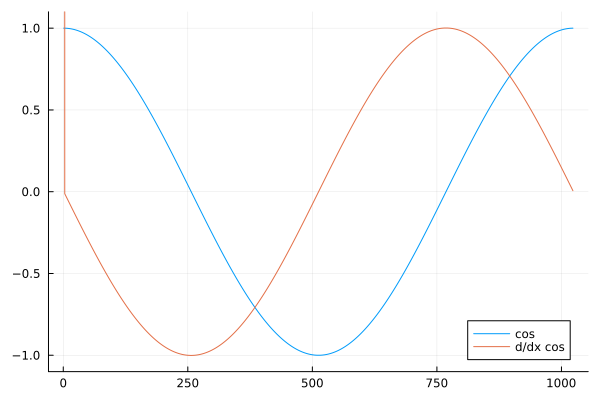

In [13]:
plot(xvec, yvec, ylim=(-1.1,1.1), label="cos")
plot!(xvec, yvec_diff, label="d/dx cos")

# 12.11.2025
## Techbase - Quantencomputing Convention
## Steve Schuhmann 